In [645]:
#JH code
import numpy as np
import h5py
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import tables
def gaus(x, a, b, c):
    return a * np.exp(-(x-b)**2/(2*c**2))
pulsedata = h5py.File('/home/jake/Downloads/DATA_600v_cs.h5', 'r')
#pulsedata = h5py.File('/home/jake/Downloads/DATA_cs_cathode_900V.h5', 'r')
#pulsedata = h5py.File('/home/jake/Documents/CZT_final/CZT-finallab/DATA_600v_cs.h5', 'r')
dat = pulsedata['EventData']
#Remove problem pixels (6,7)
dat = dat[dat['detector']<8]
anode_dat = np.zeros((dat.shape[0],8))
cathode_dat = np.zeros((dat.shape[0],8))
idx = 0
idx1 = 0 
window = 100 #incriments of 20ns
#coincidence window set based on approx charge collection time of ______

#Sort data into anode and cathode dat.shape[0]
for r in range(0,dat.shape[0]):
    if dat[r][2] >=1:
        anode_dat[idx,0:7] = dat[r].astype(list)
        idx = idx + 1
    else:
        cathode_dat[idx1,0:7] = dat[r].astype(list)
        idx1 = idx1 + 1
        
#Determine number of cathode pulses
nmax = idx1
        
#print('here')

#Sort anode data into pixels, arrange in 3D array
px_dat = np.zeros((anode_dat.shape[0],anode_dat.shape[1],8))

for y in range(0,8):
    q = anode_dat[anode_dat[:,2]==y,:]
    px_dat[0:q.shape[0],:,y] = q 

0.005659891890849544


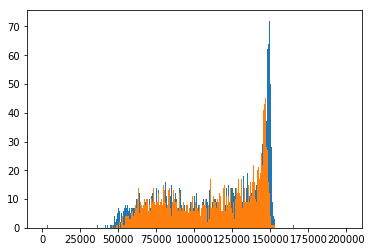

In [646]:
#Yicheng's code
h5=tables.open_file('/home/jake/Downloads/DATA_900.h5','r')
h52=tables.open_file('/home/jake/Downloads/DATA_700(2).h5','r')
edata=h5.root.EventData.read()
edata2=h52.root.EventData.read()

detmask=edata['detector']==4
detmask2=edata2['detector']==4
hist1, binedge=np.histogram(edata['ADC_value'][detmask],1000,(0,2e5))
hist2, binedge=np.histogram(edata2['ADC_value'][detmask2],1000,(0,2e5))
plt.hist(edata['ADC_value'][detmask],bins=1000,range=(0,2e5))
#plt.show()
#plt.close()
plt.hist(edata2['ADC_value'][detmask2],bins=1000,range=(0,2e5))
#plt.show()
#plt.close()
max1=np.max(hist1)-17
max2=np.max(hist2)
mutau=1./np.log(float(max1)/float(max2))*(1./700-1./900)
print(mutau)

In [488]:
np.nonzero(A_val)[0].shape

(2934,)

In [647]:
#Run coincidence finding loop

w = np.zeros((nmax,9))
for u in range(0,nmax):
    diff = cathode_dat[u,0] - anode_dat[:,0]
    q = np.where(abs(diff)<window)
    w[u,0:q[0].shape[0]] = q[0]
    #print(w[u,:])
    
#Determine runtime
runtime = (np.max(dat['timestamp'])-np.min(dat['timestamp']))/2e8
print('Total acquisition time is', runtime, 'seconds')

#Create structure which holds the peak value of each event--cathode in first, anode pix in other cols
ci_pulse = np.zeros((nmax,9))

for r in range(0,nmax):
    #cathode pulse is in row 0
    ci_pulse[r,0] = cathode_dat[r,1]
    length = np.nonzero(w[r])[0].shape[0]+1
    elm = np.ndarray.tolist(np.trim_zeros(w[r]).astype(int))
    ci_pulse[r,1:length] = anode_dat[elm,1]
    #print(elm,length)
    
#Determine cathode to anode ratio for each event
C_val = ci_pulse[:,0]
A_val = np.sum(ci_pulse[:,1:9],axis=1)
A_val_mx = np.max(ci_pulse[:,1:],axis=1)

#Trim anode/cathode pulses based on noise threshold of 1E4 (anode)
#super_threshold_indices = a > thresh
#a[super_threshold_indices] = 0

Avalidx = A_val < 1.0e4
A_val[Avalidx] = 0
A_val_trim = A_val

A_val_mx_trim = np.clip(A_val_mx,1e4,1e30)

#This computes the anode-summed cathode to anode ratio
caratio_sum = np.divide(C_val, A_val_trim, out=np.zeros_like(C_val), where=A_val_trim!=0)
#This computes the max-anode cathode to anode ratio
caratio_mx = np.divide(C_val, A_val_mx_trim, out=np.zeros_like(C_val), where=A_val_mx_trim!=0)

#Create arrays which hold events which have both anode and cathode involvement
coinc_events = ci_pulse[ci_pulse[:,1]!=0]

#Use cathode/anode ratio to correct spectrum
#THIS MUST BE UPDATED TO PULL FROM Y'S CODE
mu_tau_h = mutau/100
mu_tau_e = mutau

t = 1.0 #cm
V = 800 #volts
E = V/t #volts/cm

Le = mu_tau_e*E
Lh = mu_tau_h*E

#Use endpoints to determine location of events
#min value is zero

Total acquisition time is 134.709462005 seconds


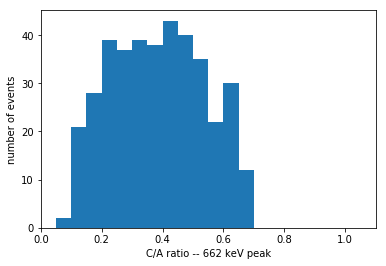

In [648]:
#Histogram CAR for high energy pulses (>ADC val 1.2E6, approx cs location)
Q_corr = np.zeros((A_val_trim.shape[0],4))
Q_corr[:,0] = A_val_trim
Q_corr[:,1] = caratio_sum
thres =1.5e6

HE_idx = Q_corr[:,0] > thres
HE_pulses = Q_corr[Q_corr[:,0]>thres]

#Create histogram of CAR for suspected Cs photopeak pulses
plt.hist(HE_pulses[:,1],bins=30, range = (0,1.5))
plt.xlabel('C/A ratio -- 662 keV peak')
plt.ylabel('number of events')
plt.xlim(0,1.1)
plt.savefig('../images/CAR_662.png')
plt.show()

#Correct for depth of interaction
x_int = np.clip(t*HE_pulses[:,1],0,1)

#x_int1 = np.ones_like(HE_pulses[:,1]) - np.clip(x_int,0,1)

for m in range(0,HE_pulses.shape[0]):
    HE_pulses[m,2] = ((Lh/t)*(1-np.exp(-(x_int[m])/Lh))+(Le/t)*(1-np.exp((x_int[m]-t)/Le)))
    HE_pulses[m,3] =  HE_pulses[m,0]/HE_pulses[m,2]
    
#Correct for depth of interaction
#(Lh/t)*(1-np.exp((-x_int1[m])/Lh))+

x_int1 = np.clip(t*Q_corr[:,1],0,1)
for m in range(0,A_val_trim.shape[0]):
    Q_corr[m,2] = Le+Lh-Le*np.exp(-(t-x_int1[m])/Le)-Lh*np.exp(-x_int1[m]/Lh) 
#((Le/t)*(1-np.exp((x_int1[m]-t)/Le)))
    Q_corr[m,3] = Q_corr[m,0]/Q_corr[m,2]
    

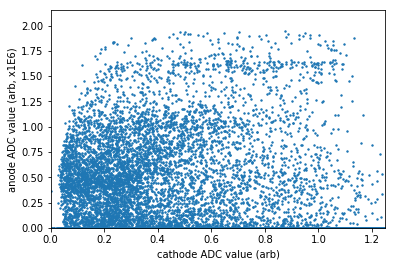

In [649]:
#Plot events in anode-cathode peak space

#Trim anode/cathode pulses based on noise threshold of 1E4 (anode)
#A_val_trim = np.clip(A_val,1e4,1e30)

plt.scatter((C_val/1e6),(A_val/1e6),s=2)
plt.xlim(0,1.25)
plt.ylim(0,2.15)
plt.ylabel("anode ADC value (arb, x1E6)")
plt.xlabel("cathode ADC value (arb)")
#plt.gcf().set_size_inches(8,6)
plt.savefig('../images/scatter.png')

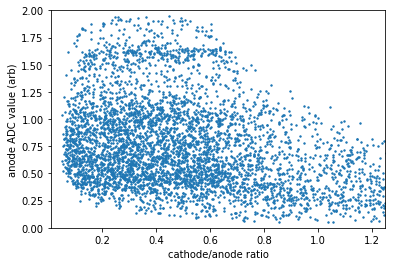

In [650]:
#Plot events in anode-cathode peak space

#Trim anode/cathode pulses based on noise threshold of 1E4 (anode)
#A_val_trim = np.clip(A_val,1e4,1e30)

plt.scatter(caratio_sum,A_val/1e6,s=2)
plt.xlim(0.01,1.25)
plt.ylim(0,2)
plt.ylabel("anode ADC value (arb)")
plt.xlabel("cathode/anode ratio")
#plt.gcf().set_size_inches(8,6)
plt.savefig('../images/scatter_CAR.png')

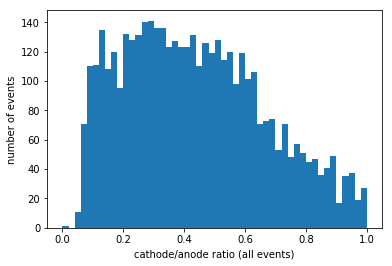

In [651]:
#Histogram C/A ratio--representing DOI
plt.hist(caratio_sum, bins=50, range = (.001,1))
plt.xlabel('cathode/anode ratio (all events)')
plt.ylabel('number of events')
plt.savefig('../images/CAR_all.png')
plt.show()

#Histogram C/A ratio--representing DOI
#plt.hist(x_int, bins=20, range = (.01,1))
#plt.xlabel('cathode/anode ratio(anode pixel max)')
#plt.ylabel('number of events')
#plt.savefig('../images/scatter.png')
#plt.show()

#Histogram C/A ratio for events at high energy (~Cs area)

#Use endpoints to determine location of events
#max value (excl. outliers) of CA ratio is 163 (event occured at cathode)
#min value is zero


FWHM is 11.21 percent


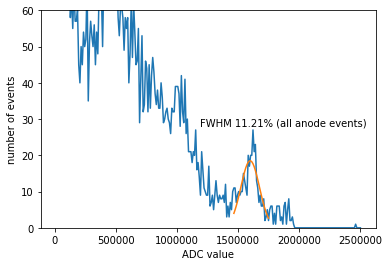

FWHM is 12.8 percent


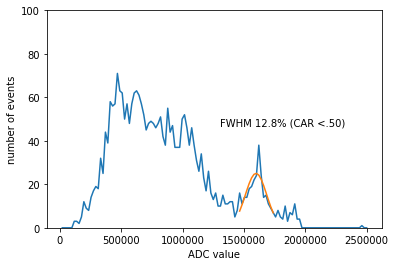

FWHM is  9.5 percent


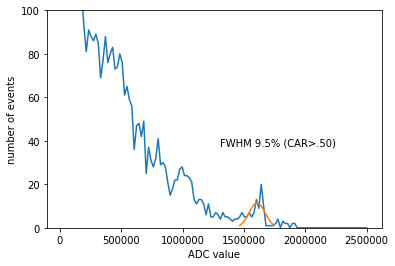

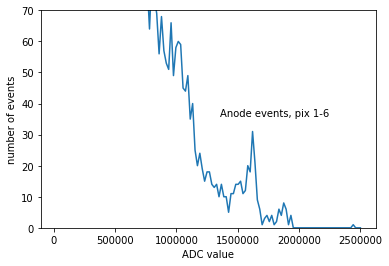

In [652]:
#Plot events with coincidences ONLY
co_sum = np.sum(coinc_events[:,1:],axis=1)
cathode_coinc = coinc_events[:,0]
n,bins = np.histogram(co_sum, bins=256, range = (10,2.5e6))

#Curve fit to peak
xdatacs = bins[150:180]
ydatacs = n[149:179]

poptcs, pcovcs = curve_fit(gaus, xdatacs, ydatacs, bounds=(((10,1.55e6,1e3), (70.,1.73E6, 2e5))))
xtest = np.arange(bins[150],(bins[150]+30),1)
ytest = gaus(bins[150:180],poptcs[0],poptcs[1],poptcs[2])

FWHM_un =  np.around((2.355*100*poptcs[2])/poptcs[1], decimals=3)

name = "FWHM " +str(FWHM_un) +"% (all anode events)"
plt.annotate( name, xy=(200, 140), xycoords='figure pixels')

plt.plot(bins[1:],n)
plt.plot(xdatacs,ytest)

print('FWHM is',FWHM_un, 'percent')
plt.xlabel('ADC value')
plt.ylabel('number of events')

plt.ylim(0,60)
plt.xlabel('ADC value')
plt.ylabel('number of events')
plt.savefig('../images/CAR_all.png')
plt.show()




#-----------------------------------------------------------





#Plot events with DOI <1/2
Q_sh = Q_corr[Q_corr[:,1]<.5]
n1,bins1 = np.histogram(Q_sh[:,0], bins=128, range=(10,2.5e6))
#plt.plot(bins1[1:],n1)
#Curve fit to peak
xdatacs1 = bins1[75:90]
ydatacs1 = n1[74:89]

poptcs1, pcovcs1 = curve_fit(gaus, xdatacs1, ydatacs1, bounds=(((10,1.55e6,1e3), (70.,1.73E6, 2e5))))
xtest1 = np.arange(bins1[75],(bins1[75]+15),1)
ytest1 = gaus(bins1[75:90],poptcs1[0],poptcs1[1],poptcs1[2])

#Overlay FWHM data (1)
#plt.plot(bins1[1:],n1)
#plt.plot(xdatacs1,ytest1)
FWHM_un1 =  np.around((2.355*poptcs1[2])/poptcs1[1], decimals=3)

name1 = "FWHM " +str(FWHM_un1*100) +"% (CAR <.50)"
plt.annotate( name1, xy=(220, 140), xycoords='figure pixels')

plt.plot(bins1[1:],n1)
plt.plot(xdatacs1,ytest1)

plt.ylim(0,100)
plt.xlabel('ADC value')
plt.ylabel('number of events')
plt.savefig('../images/CAR1_all.png')

print('FWHM is',FWHM_un1*100, 'percent')
plt.xlabel('ADC value')
plt.ylabel('number of events')

plt.show()



#-------------------------------------------------------------




#Plot events with DOI >1/2
Q_sh1 = Q_corr[Q_corr[:,1]>.5]
n2,bins2 = np.histogram(Q_sh1[:,0], bins=128, range=(10,2.5e6))
#plt.plot(bins2[1:],n2)
plt.xlabel('ADC value')
plt.ylabel('number of events')
plt.ylim(0,100)
#plt.show()

#Curve fit to peak
xdatacs2 = bins2[75:90]
ydatacs2 = n2[74:89]

poptcs2, pcovcs2 = curve_fit(gaus, xdatacs2, ydatacs2, bounds=(((10,1.55e6,1e4), (70.,1.73E6, 2e5))))
xtest2 = np.arange(bins2[75],(bins2[75]+15),1)
ytest2 = gaus(bins2[75:90],poptcs2[0],poptcs2[1],poptcs2[2])

#Overlay FWHM data (2)
plt.plot(bins2[1:],n2)
plt.plot(xdatacs2,ytest2)
FWHM_un2 =  np.around((2.355*poptcs2[2])/poptcs2[1], decimals=3)
name2 = "FWHM " +str(FWHM_un2*100) + "% (CAR>.50)"
plt.annotate( name2, xy=(220, 120), xycoords='figure pixels')

plt.ylim(0,100)
plt.xlabel('ADC value')
plt.ylabel('number of events')
plt.savefig('../images/CAR2_all.png')

print('FWHM is ',FWHM_un2*100, 'percent')
plt.show()


#Plot all anode events with
#Q_sh2 
im = dat[dat['detector']>0]
im2 = im[im['detector']<6]
Q_sh2 = im2['ADC_value']
n3,bins3 = np.histogram(Q_sh2, bins=128, range=(10,2.5e6))
plt.plot(bins3[1:],n3)
plt.xlabel('ADC value')
plt.ylabel('number of events')
name3 = "Anode events, pix 1-6" 
plt.annotate( name3, xy=(220, 150), xycoords='figure pixels')
plt.ylim(0,70)
plt.savefig('../images/anodes_1_6.png')
plt.show()

#Curve fit to peak
#xdatacs3 = bins3[150:180]
#ydatacs3 = n3[149:179]

#poptcs3, pcovcs3 = curve_fit(gaus, xdatacs3, ydatacs3, bounds=(((5,1.55e6,1e4), (18.,1.73E6, 2e5))))
#xtest3 = np.arange(bins3[150],(bins3[150]+30),1)
#ytest3 = gaus(bins3[150:180],poptcs3[0],poptcs3[1],poptcs3[2])

#Overlay FWHM data (2)
#plt.plot(bins3[1:],n3)
#plt.plot(xdatacs3,ytest3)
#FWHM_un3 =  np.around((2.355*poptcs3[2])/poptcs3[1], decimals=3)
#name3 = "FWHM " +str(FWHM_un3*100) + "% (CAR>.35)"
#plt.annotate( name3, xy=(220, 120), xycoords='figure pixels')

#plt.ylim(0,30)
#plt.xlabel('ADC value')
#plt.ylabel('number of events')
#plt.savefig('../images/CAR3_all.png')

#print('{FWHM is }',FWHM_un3*100, 'percent')
#plt.show()


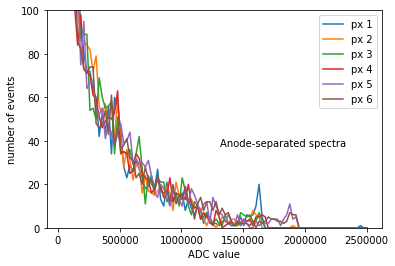

In [656]:
#Plot anode spectrum from each pixel
for n in range (1,7):
    dd = px_dat[:,1,n]
    n4,bins4 = np.histogram(dd, bins=100, range = (1e4,2.5e6))
    plt.plot(bins4[1:],n4)
    plt.ylim(0,100)
    name = "Anode Pixel " + str(n)
    plt.xlabel('ADC value')
    plt.legend(("px 1","px 2","px 3","px 4","px 5","px 6","px 7"))
    plt.ylabel('number of events')

    name_file = "../images/anode_px" +".png"

plt.annotate( "Anode-separated spectra", xy=(220, 120), xycoords='figure pixels')
plt.savefig(name_file)
plt.show()


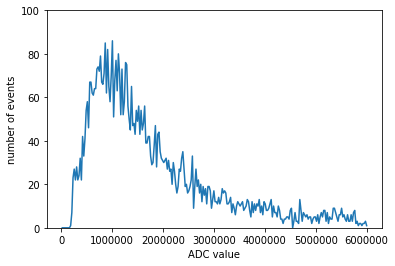

In [654]:
d5 = Q_corr[:,3]
n5,bins5 = np.histogram(d5, bins=256, range = (10,6e6))
plt.plot(bins5[1:],n5)
plt.xlabel('ADC value')
plt.ylabel('number of events')
plt.ylim(0,100)
plt.savefig('../images/corr_anode_pulses.png')
plt.show()

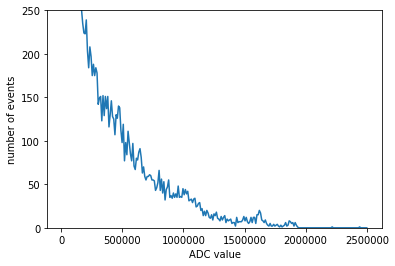

In [655]:
im3 = dat[dat['detector']>0]
Q_sh3 = im3['ADC_value']
n4,bins4 = np.histogram(Q_sh3, bins=256, range=(10,2.5e6))
plt.plot(bins4[1:],n4)
plt.xlabel('ADC value')
plt.ylabel('number of events')
plt.ylim(0,250)
plt.savefig('../images/all_anode_pulses.png')
plt.show()

In [99]:
#/RawData (EArray(25254, 4096), shuffle, zlib(1)) ''
#  atom := Int32Atom(shape=(), dflt=0)
#  maindim := 0
#  flavor := 'numpy'
#  byteorder := 'little'
#  chunkshape := (8, 4096)

9578